In [1]:
###Import Packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import pingouin as pg
from numpy import std, mean, sqrt

In [2]:
#Import the corrected dataframe
df = pd.read_csv('persuade_corpus_corrected.csv', low_memory=False)
df1 = df[["essay_id", "holistic_score_adjudicated", "gender", "grade", "ell", 
          "race_ethnicity", "economically_disadvantaged", 
          "student_disability_status", "essay_word_count", "number_of_sentences", "prompt_name"]].drop_duplicates()

#Fill the nans with Status unknown
df1["ell"] = df1["ell"].replace(" ", "Status Unknown")
df1.fillna('Status unknown', inplace = True)

<AxesSubplot:xlabel='economically_disadvantaged', ylabel='holistic_score_adjudicated'>

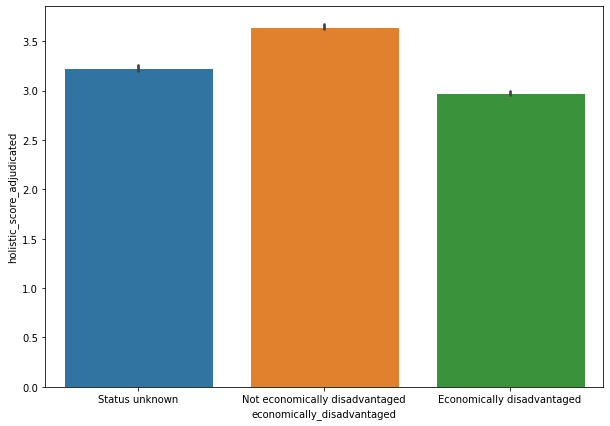

In [3]:
#I used this frame to produce most of my graphs by changing the variables
#Economic disadvantage
plt.figure(figsize=(10, 7))
plt.xticks(rotation=0)
sns.set_style("darkgrid")
sns.barplot(x="economically_disadvantaged", y="holistic_score_adjudicated", data = df1)


#ax = sns.boxplot(x="ell", y="holistic_essay_score", 
#                 showmeans = True, 
#                 meanprops={"marker":"o",
#                       "markerfacecolor":"white", 
#                       "markeredgecolor":"black",
#                       "markersize":"10"},
#                 data=df1[df1["ell"]!=" "])


In [4]:
#This is a function to output descriptive data in csv format

def descriptive1(metavariable):
    variables = pd.Series(df1[metavariable].unique()).dropna()
    for variable in variables:
        var_list = []
        average = df1[df1[metavariable] == variable]["holistic_score_adjudicated"]
        print(variable, ',', len(average), ",", round(average.mean(), 2), ",", round(average.std(), 2))
    print('total', ',', len(df1), ',', round(df1["holistic_score_adjudicated"].mean(),2), ',', round(df1["holistic_score_adjudicated"].std(),2))
    

descriptive1("economically_disadvantaged")


Status unknown , 5237 , 3.23 , 1.11
Not economically disadvantaged , 11116 , 3.65 , 1.17
Economically disadvantaged , 9643 , 2.98 , 1.06
total , 25996 , 3.32 , 1.16


In [51]:
#This is a function to run ttests. It outputs in a useful format

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)

def DF(x,y):
    return len(x)+len(y)-2

def ttest(metavariable, score):
    variables = df1[metavariable].dropna().unique().tolist()
    if 'Status unknown' in variables:    
        variables.remove('Status unknown')
    if len(variables) > 2:
        print('ERROR: too many variables')
    x = df1[df1[metavariable] == variables[0]][score]
    y = df1[df1[metavariable] == variables[1]][score]
    stat = round(ttest_ind(x,y).statistic, 2)
    p = round(ttest_ind(x,y).pvalue, 3)
    d = round(cohen_d(x, y), 2)
    df = int(DF(x,y))
    print('t({}) = {}, p = {}, d = {}'.format(df, stat, p, d))

variables = pd.Series(df1['ell'].dropna().unique())

    
ttest('gender', 'holistic_score_adjudicated')

t(25994) = -15.75, p = 0.0, d = -0.2


In [7]:
#This function outputs anova data in a useful format

dfDis = df1[df1["economically_disadvantaged"] == 'Not economically disadvantaged']
print(df1.economically_disadvantaged.value_counts())

def anova(metavariable, score):
    aov = pg.anova(dv=score, between=metavariable, data=dfDis, detailed=True)
    f=round(int(aov['F'][0]), 0)
    df=(round(aov['DF'][0], 2))
    p=(round(aov['p-unc'][0], 3))
    eta=(round(aov['np2'][0], 3))
    print(aov)
    print('f({}) = {}, p = {}, eta2 = {}'.format(df, f, p, eta))

anova('race_ethnicity', 'holistic_score_adjudicated')

Not economically disadvantaged    11116
Economically disadvantaged         9643
Status unknown                     5237
Name: economically_disadvantaged, dtype: int64
           Source            SS     DF         MS          F         p-unc  \
0  race_ethnicity    444.167517      5  88.833503  66.415946  1.374201e-68   
1          Within  14859.988924  11110   1.337533        NaN           NaN   

        np2  
0  0.029023  
1       NaN  
f(5) = 66, p = 0.0, eta2 = 0.029


In [8]:
# For the pair-wise post hocs. It outputs to a csv table.

dfDis = df#1[df1["economically_disadvantaged"] == 'Economically disadvantaged']
tukey = pairwise_tukeyhsd(endog=dfDis['holistic_score_adjudicated'], groups=dfDis['race_ethnicity'], alpha=0.05)

tukeydf = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
tukeydf.to_csv('table.csv')

In [13]:
###MAKE A DATAFRAME WITH DISCOURSE TYPES
# This makes a long dataframe where 0 values are filled in for discourse element counts, providing eight 
# total entries for each essay.

#Count the discourse types
dt = df.groupby("essay_id")["discourse_type"].value_counts()

#Fill in blanks with zeros
new_index = pd.MultiIndex.from_product(dt.index.levels)
new_frame = dt.reindex(new_index)
new_frame = new_frame.fillna(0).astype(int)

#Flatten the multiindex
new_frame = new_frame.to_frame()
new_frame.columns = ['count']
dt_flat = new_frame.reset_index()

#Merge the index with the metadata
dfLong = pd.merge(dt_flat, df1, on="essay_id", how="right")
print(df1.count(), dfLong.count())

essay_id                      25996
holistic_score_adjudicated    25996
gender                        25996
grade                         25996
ell                           25996
race_ethnicity                25996
economically_disadvantaged    25996
student_disability_status     25996
essay_word_count              25996
number_of_sentences           25996
prompt_name                   25996
dtype: int64 essay_id                      207968
discourse_type                207968
count                         207968
holistic_score_adjudicated    207968
gender                        207968
grade                         207968
ell                           207968
race_ethnicity                207968
economically_disadvantaged    207968
student_disability_status     207968
essay_word_count              207968
number_of_sentences           207968
prompt_name                   207968
dtype: int64


<Figure size 1080x504 with 0 Axes>

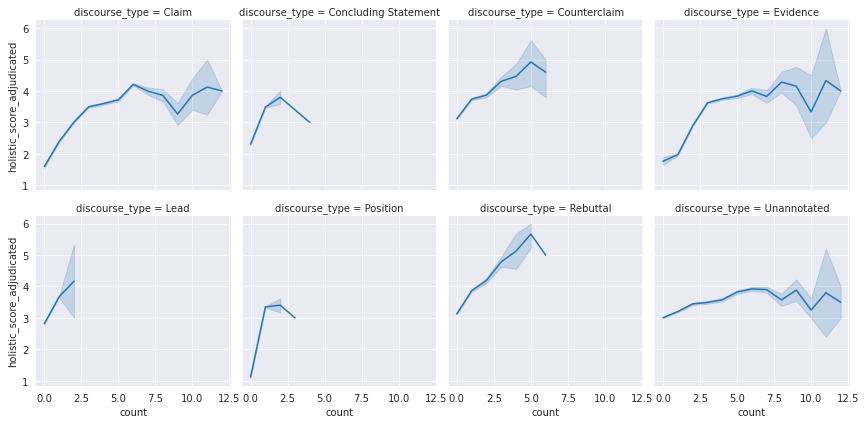

In [14]:
# This creates a facetgrid of the different types of discourse counts

plt.figure(figsize=(15,7))
sea = sns.FacetGrid(dfLong, col = "discourse_type", col_wrap=4)

sea.map(sns.lineplot, "count","holistic_score_adjudicated")

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'Claim'),
  Text(1, 0, 'Concluding Statement'),
  Text(2, 0, 'Counterclaim'),
  Text(3, 0, 'Evidence'),
  Text(4, 0, 'Lead'),
  Text(5, 0, 'Position'),
  Text(6, 0, 'Rebuttal'),
  Text(7, 0, 'Unannotated')])

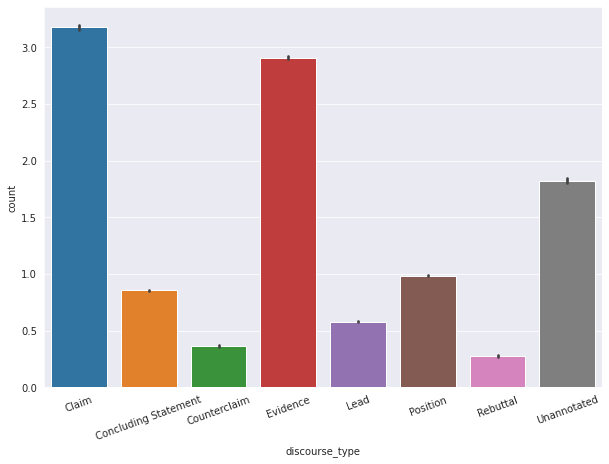

In [21]:
plt.figure(figsize=(10, 7))
plt.xticks(rotation=0)
sns.set_style("darkgrid")
sns.barplot(x="discourse_type", y="count", data = dfLong)
plt.xticks(rotation=20)

In [22]:
# Here is another handy descriptive data generator for average number of discourse elements

def descriptiveCounts(metavariable):
    variables = pd.Series(df_discourse_counts[metavariable].unique()).dropna()
    for variable in variables:
        var_list = []
        scores = dfLong[dfLong[metavariable] == variable]["count"]
        print(variable, ',', sum(scores), ",", round(scores.mean(), 2), ",", round(scores.std(), 2))
    print('total', ',', len(dfLong), ',', round(dfLong["count"].mean(),2), ',', round(dfLong["count"].std(),2))
    

descriptiveCounts("discourse_type")

Claim , 82584 , 3.18 , 1.77
Concluding Statement , 22283 , 0.86 , 0.37
Counterclaim , 9534 , 0.37 , 0.65
Evidence , 75588 , 2.91 , 1.18
Lead , 15098 , 0.58 , 0.49
Position , 25669 , 0.99 , 0.14
Rebuttal , 7217 , 0.28 , 0.56
Unannotated , 47410 , 1.82 , 1.87
total , 207968 , 1.37 , 1.51


In [23]:
### ANALYSIS OF PROMPTS
df = pd.read_csv("persuade_corpus_corrected.csv", low_memory=False)

# Change the names of the prompt_name variable
df['prompt_name'] = df['prompt_name'].replace(['"A Cowboy Who Rode the Waves"',
 'Car-free cities',
 'Cell phones at school',
 'Community service',
 'Distance learning',
 'Does the electoral college work?',
 'Driverless cars',
 'Exploring Venus',
 'Facial action coding system',
 'Grades for extracurricular activities',
 'Mandatory extracurricular activities',
 'Phones and driving',
 'Seeking multiple opinions',
 'Summer projects',
 'The Face on Mars'],['Dep-6_Cowboy', 'Dep-10_Car-free', 'Ind-8_CellPhones', 'Ind-8_ComService', 
                      'Ind-9,10,11,12_DistLearn', 'Dep-9_Electoral', 'Dep-10_Driverless',
                     'Dep-10_Venus', 'Dep-10_Facial', 'Ind-8_GradesAct', 'Ind-8_MandAct', 
                      'Ind-9,10,11,12_PhonesDrive', 'Ind-8_MultOpin', 'Ind-9,10,11,12_Summerproj', 'Dep-8_MarsFace'])

# Reorder them
df['prompt_name'] = df['prompt_name'].astype('category')
df['prompt_name'].cat.reorder_categories(['Dep-6_Cowboy',
                                             'Dep-8_MarsFace',
                                             'Dep-9_Electoral',
                                             'Dep-10_Car-free',
                                             'Dep-10_Driverless',
                                             'Dep-10_Facial',
                                             'Dep-10_Venus',
                                             'Ind-8_CellPhones',
                                             'Ind-8_ComService',
                                             'Ind-8_GradesAct',
                                             'Ind-8_MandAct',
                                             'Ind-8_MultOpin',
                                             'Ind-9,10,11,12_DistLearn',
                                             'Ind-9,10,11,12_PhonesDrive',
                                             'Ind-9,10,11,12_Summerproj'], inplace=True)

#CREATE A LONG VERSION OF THE DATAFRAME
df1 = df[["essay_id", "holistic_score_adjudicated", "prompt_name", "gender", "grade", "ell", 
          "race_ethnicity", "economically_disadvantaged", 
          "student_disability_status", "essay_word_count", "number_of_sentences", "task"]].drop_duplicates()

df1["ell"] = df1["ell"].replace(" ", "Status unknown")
df1['ell'].fillna('Status unknown', inplace = True)
df1['economically_disadvantaged'].fillna('Status unknown', inplace = True)


#Count the discourse types
dt = df.groupby("essay_id")["discourse_type"].value_counts()

#Fill in blanks with zeros
new_index = pd.MultiIndex.from_product(dt.index.levels)
new_frame = dt.reindex(new_index)
new_frame = new_frame.fillna(0).astype(int)

#Flatten the multiindex
new_frame = new_frame.to_frame()
new_frame.columns = ['count']
dt_flat = new_frame.reset_index()

#Merge the index with the metadata
dfLong = pd.merge(dt_flat, df1, on="essay_id", how="right")

print(dfLong.count())

essay_id                      207968
discourse_type                207968
count                         207968
holistic_score_adjudicated    207968
prompt_name                   207968
gender                        207968
grade                         207968
ell                           207968
race_ethnicity                207968
economically_disadvantaged    207968
student_disability_status     198624
essay_word_count              207968
number_of_sentences           207968
task                          207968
dtype: int64


In [24]:
# Save the long version to a file
dfLong.to_csv("dfLong.csv")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'Dep-6_Cowboy'),
  Text(1, 0, 'Dep-8_MarsFace'),
  Text(2, 0, 'Dep-9_Electoral'),
  Text(3, 0, 'Dep-10_Car-free'),
  Text(4, 0, 'Dep-10_Driverless'),
  Text(5, 0, 'Dep-10_Facial'),
  Text(6, 0, 'Dep-10_Venus'),
  Text(7, 0, 'Ind-8_CellPhones'),
  Text(8, 0, 'Ind-8_ComService'),
  Text(9, 0, 'Ind-8_GradesAct'),
  Text(10, 0, 'Ind-8_MandAct'),
  Text(11, 0, 'Ind-8_MultOpin'),
  Text(12, 0, 'Ind-9,10,11,12_DistLearn'),
  Text(13, 0, 'Ind-9,10,11,12_PhonesDrive'),
  Text(14, 0, 'Ind-9,10,11,12_Summerproj')])

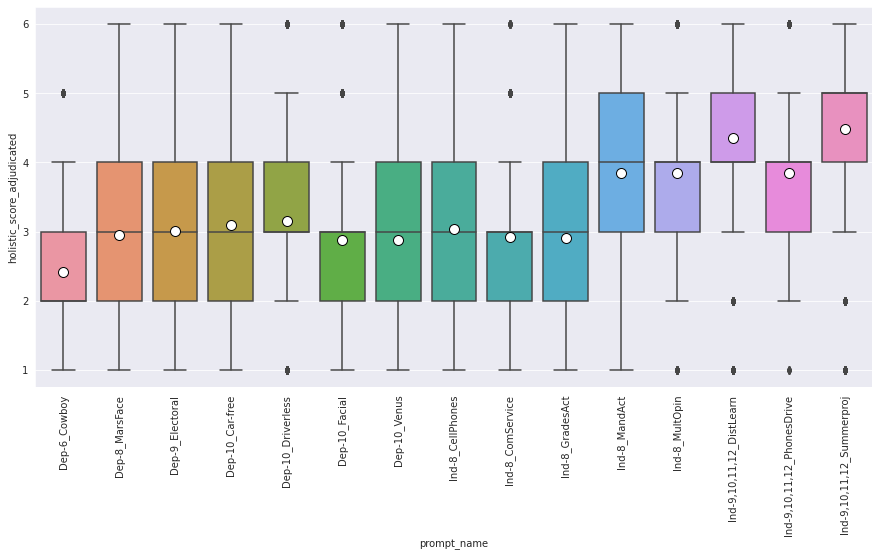

In [25]:
# BOXPLOT THE PROMPTS WITH HOLISTIC ESSAY SCORE

plt.figure(figsize=(15, 7))
sns.set_style("darkgrid")
sns.boxplot(x="prompt_name", y="holistic_score_adjudicated", showmeans = True, 
                 meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"10"},
                 data = dfLong)
plt.xticks(rotation = 90)


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

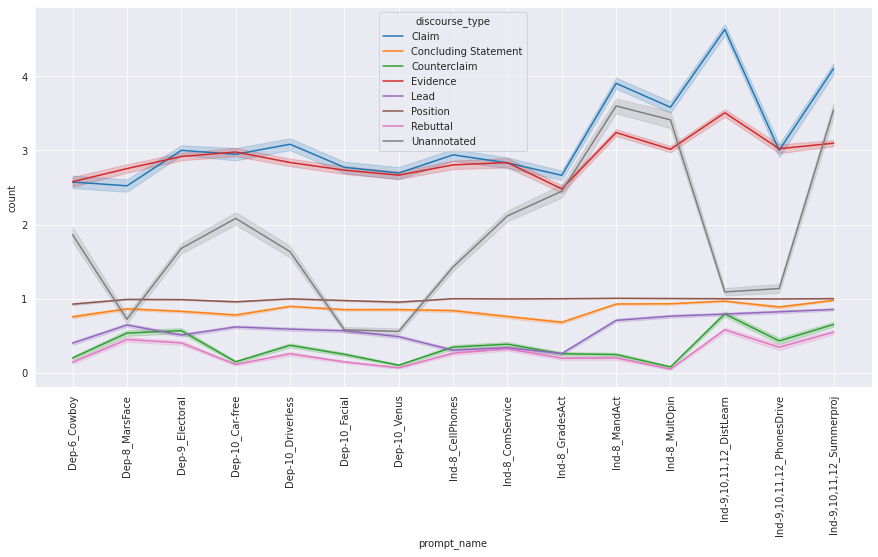

In [26]:
# Line plot the counts of the discourse elements per prompt
plt.figure(figsize=(15, 7))
sns.set_style("darkgrid")
sns.lineplot(x="prompt_name", y="count", hue="discourse_type", data = dfLong)
plt.xticks(rotation = 90)

In [28]:
# GENERATE DESCRIPTIVE DATA FOR COUNTS OF DISCOURSE ELEMENTS DEPENDING ON TASK TYPE
# This requires dfWide.csv generated by the r script building_wide_df.r

dfWide = pd.read_csv('dfWide.csv')
discourse_types = dfLong.discourse_type.unique()
discourse_types = pd.Series(discourse_types).dropna()

def descriptive(metavariable):
    variables = pd.Series(dfLong[metavariable].unique()).dropna()
    for variable in variables:
        print(variable)
    for variable in variables:
        row = []
        for discourse in discourse_types:
            n = round(dfWide[dfWide[metavariable] == variable][discourse].sum(), 2)
            m = round(dfWide[dfWide[metavariable] == variable][discourse].mean(), 2)
            sd = round(dfWide[dfWide[metavariable] == variable][discourse].std(), 2)
            row.append(n)
            row.append(m)
            row.append(sd)
        print(list(discourse_types))
        print(row)
descriptive("task")

Independent
Text dependent
['Claim', 'Concluding Statement', 'Counterclaim', 'Evidence', 'Lead', 'Position', 'Rebuttal', 'Unannotated']
[46312, 3.53, 1.7, 11514, 0.88, 0.34, 5502, 0.42, 0.68, 39652, 3.02, 1.15, 8006, 0.61, 0.49, 13144, 1.0, 0.07, 4308, 0.33, 0.6, 30802, 2.35, 1.97]
['Claim', 'Concluding Statement', 'Counterclaim', 'Evidence', 'Lead', 'Position', 'Rebuttal', 'Unannotated']
[36272, 2.82, 1.75, 10769, 0.84, 0.39, 4032, 0.31, 0.61, 35936, 2.79, 1.2, 7092, 0.55, 0.5, 12525, 0.97, 0.18, 2909, 0.23, 0.52, 16608, 1.29, 1.6]


In [29]:
# More descriptive data showing average scores according to different variables

def descriptive1(metavariable):
    variables = pd.Series(dfWide[metavariable].unique()).dropna()
    for variable in variables:
        print(variable)
    for variable in variables:
        average = dfWide[dfWide[metavariable] == variable]["holistic_score_adjudicated"]
        print(len(average), ",", round(average.mean(), 2), ",", round(average.std(), 2))
    total = dfWide['holistic_score_adjudicated']
    print(len(total), ',', round(total.mean(),2), ',', round(total.std(), 2))
descriptive1("task")

Independent
Text dependent
13121 , 3.69 , 1.12
12875 , 2.93 , 1.07
25996 , 3.32 , 1.16


In [49]:
# T-test generator again

from numpy import std, mean, sqrt

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)

def DF(x,y):
    return len(x)+len(y)-2

def ttest(metavariable, score):
    variables = df1[metavariable].dropna().unique().tolist()
    if 'Status unknown' in variables:
        variables.remove('Status unknown')
    if len(variables) > 2:
        print('ERROR: too many variables')
    x = dfWide[dfWide[metavariable] == variables[0]][score]
    y = dfWide[dfWide[metavariable] == variables[1]][score]
    stat = round(ttest_ind(x,y).statistic, 2)
    p = round(ttest_ind(x,y).pvalue, 3)
    d = round(cohen_d(x, y), 2)
    df = int(DF(x,y))
    print('t({}) = {}, p = {}, d = {}'.format(df, stat, p, d))
    
ttest('task', 'holistic_score_adjudicated')

t(25994) = 55.8, p = 0.0, d = 0.69


<AxesSubplot:xlabel='task', ylabel='holistic_score_adjudicated'>

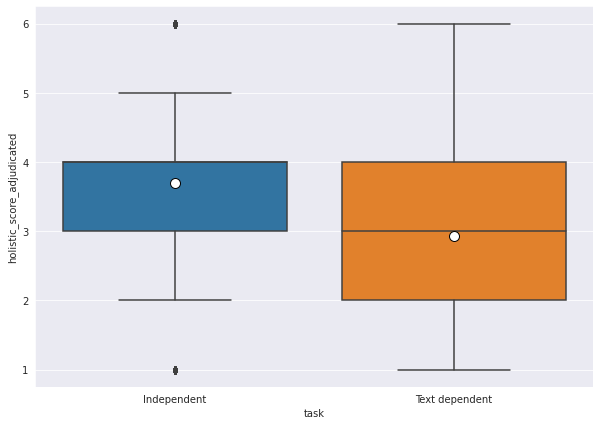

In [31]:
# Boxplot of Independent/Text Dependent

plt.figure(figsize=(10, 7))

sns.boxplot(x="task", y="holistic_score_adjudicated", showmeans = True, 
                 meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"10"},data=dfWide)